# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('X_dev:',X_dev.shape)
print('y_dev:',y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
X_dev: (500, 32, 32, 3)
y_dev: (500,)


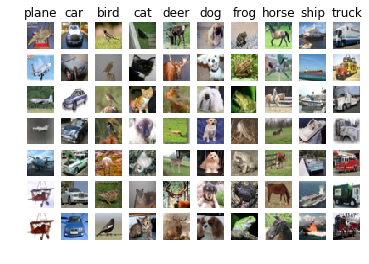

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


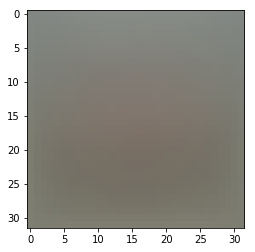

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.440523


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

(1110, 7)
numerical: 2.490787 analytic: 2.490787, relative error: 7.523401e-11
(1438, 1)
numerical: -12.040313 analytic: -12.040313, relative error: 8.840170e-12
(2304, 1)
numerical: -4.906949 analytic: -4.906949, relative error: 5.004531e-11
(2986, 9)
numerical: -9.164179 analytic: -9.132680, relative error: 1.721544e-03
(738, 8)
numerical: -9.132000 analytic: -9.132000, relative error: 1.036685e-11
(365, 0)
numerical: -30.507050 analytic: -30.507050, relative error: 1.537795e-12
(2979, 5)
numerical: 3.393910 analytic: 3.336322, relative error: 8.556674e-03
(1521, 9)
numerical: 6.977400 analytic: 6.977400, relative error: 2.192740e-11
(1578, 3)
numerical: -1.441323 analytic: -1.441323, relative error: 8.064188e-11
(868, 9)
numerical: -26.071257 analytic: -26.071257, relative error: 1.086769e-11
(2292, 6)
numerical: -11.113778 analytic: -11.113778, relative error: 1.108207e-12
(2376, 3)
numerical: -2.617446 analytic: -2.617446, relative error: 2.350837e-11
(2484, 4)
numerical: 5.546281

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
print(W.shape)
print(X_dev.shape)
print(type(W))
print(type(X_dev))
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))
print("-------------------------------------------------------------------------------------------------")
print(W.shape)
print(X_dev.shape)
print(type(W))
print(type(X_dev))
from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

(3073, 10)
(500, 3073)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Naive loss: 9.440523e+00 computed in 0.107711s
-------------------------------------------------------------------------------------------------
(3073, 10)
(500, 3073)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Vectorized loss: 9.951647e+00 computed in 0.005395s
difference: -0.511124


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.107713s
Vectorized loss and gradient: computed in 0.004992s
difference: 156.079599


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [11]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 404.499368
iteration 100 / 1500: loss 258.713643
iteration 200 / 1500: loss 172.695018
iteration 300 / 1500: loss 120.937558
iteration 400 / 1500: loss 98.469681
iteration 500 / 1500: loss 79.374115
iteration 600 / 1500: loss 59.559257
iteration 700 / 1500: loss 54.199195
iteration 800 / 1500: loss 53.507139
iteration 900 / 1500: loss 51.330212
iteration 1000 / 1500: loss 47.064143
iteration 1100 / 1500: loss 52.366484
iteration 1200 / 1500: loss 40.043187
iteration 1300 / 1500: loss 50.035896
iteration 1400 / 1500: loss 46.185713
That took 6.635670s


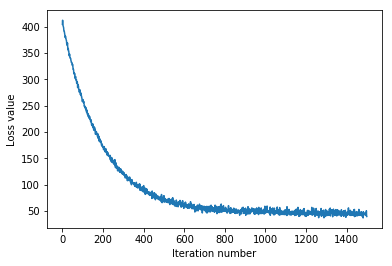

In [12]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.277673
validation accuracy: 0.296000


In [25]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-7,2e-7, 3e-7, 5e-5, 8e-7]
regularization_strengths = [1e5, 8e5, 3e5, 4e5, 5e5, 6e5, 7e5, 6e4, 1e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        train_svm=LinearSVM()
        train_svm.train(X_train, y_train, learning_rate=lr, reg=rs,num_iters=1500, verbose=True)
        y_train_pred=train_svm.predict(X_train)
        y_val_pred=train_svm.predict(X_val)
        val_accuracy=np.mean(y_val_pred==y_val)
        train_accuracy=np.mean(y_train_pred==y_train)
        results[(lr,rs)]=(train_accuracy,val_accuracy)
        
        if(val_accuracy>best_val):
            print("当前最佳的准确率为：")
            print(val_accuracy)
            best_val=val_accuracy
            best_svm=train_svm
    

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, rs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, rs, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 1557.411157
iteration 100 / 1500: loss 226.475015
iteration 200 / 1500: loss 47.996629
iteration 300 / 1500: loss 24.512038
iteration 400 / 1500: loss 22.136696
iteration 500 / 1500: loss 24.747952
iteration 600 / 1500: loss 21.980012
iteration 700 / 1500: loss 22.730759
iteration 800 / 1500: loss 22.631998
iteration 900 / 1500: loss 20.635495
iteration 1000 / 1500: loss 22.917415
iteration 1100 / 1500: loss 21.217650
iteration 1200 / 1500: loss 24.848590
iteration 1300 / 1500: loss 23.005075
iteration 1400 / 1500: loss 19.950823
当前最佳的准确率为：
0.301
iteration 0 / 1500: loss 12267.041294
iteration 100 / 1500: loss 13.525203
iteration 200 / 1500: loss 12.734052
iteration 300 / 1500: loss 13.521818
iteration 400 / 1500: loss 12.813055
iteration 500 / 1500: loss 13.550073
iteration 600 / 1500: loss 12.721454
iteration 700 / 1500: loss 13.054660
iteration 800 / 1500: loss 13.259794
iteration 900 / 1500: loss 12.789673
iteration 1000 / 1500: loss 12.817531
iteration 110

iteration 900 / 1500: loss 15.104926
iteration 1000 / 1500: loss 13.937190
iteration 1100 / 1500: loss 12.975882
iteration 1200 / 1500: loss 13.766991
iteration 1300 / 1500: loss 13.739392
iteration 1400 / 1500: loss 13.557476
iteration 0 / 1500: loss 10828.185671
iteration 100 / 1500: loss 12.449963
iteration 200 / 1500: loss 12.384655
iteration 300 / 1500: loss 13.882854
iteration 400 / 1500: loss 12.925047
iteration 500 / 1500: loss 14.708645
iteration 600 / 1500: loss 12.729789
iteration 700 / 1500: loss 13.106536
iteration 800 / 1500: loss 12.820705
iteration 900 / 1500: loss 13.950564
iteration 1000 / 1500: loss 13.324286
iteration 1100 / 1500: loss 13.729828
iteration 1200 / 1500: loss 12.738800
iteration 1300 / 1500: loss 12.486687
iteration 1400 / 1500: loss 14.112170
iteration 0 / 1500: loss 956.099782
iteration 100 / 1500: loss 107.760221
iteration 200 / 1500: loss 34.641218
iteration 300 / 1500: loss 29.343351
iteration 400 / 1500: loss 28.688372
iteration 500 / 1500: loss 

iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 4678.933608
iteration 100 / 1500: loss 78616369107957220887055135363716036060844303333530145677310307856889912416456567929952316325603074451409318803999572370012577172707662249000462333463595277566156126809487167852764836475330198222581711292422148468241520345071482830848.000000
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 6234.075052
iteration 100 / 1500: loss 350574957833093874942301884967696268373238072099510460020278021994333004014403173422363497810229074035356992898648806011860391593256578068201151714816371320290

iteration 1200 / 1500: loss 15.880240
iteration 1300 / 1500: loss 15.960669
iteration 1400 / 1500: loss 15.549995
iteration 0 / 1500: loss 9312.499833
iteration 100 / 1500: loss 14.180168
iteration 200 / 1500: loss 15.649301
iteration 300 / 1500: loss 14.839622
iteration 400 / 1500: loss 14.922345
iteration 500 / 1500: loss 14.959155
iteration 600 / 1500: loss 16.560850
iteration 700 / 1500: loss 14.359650
iteration 800 / 1500: loss 16.732370
iteration 900 / 1500: loss 15.652537
iteration 1000 / 1500: loss 14.315893
iteration 1100 / 1500: loss 14.205200
iteration 1200 / 1500: loss 15.795077
iteration 1300 / 1500: loss 15.707484
iteration 1400 / 1500: loss 15.020765
iteration 0 / 1500: loss 10693.622696
iteration 100 / 1500: loss 15.778333
iteration 200 / 1500: loss 14.862236
iteration 300 / 1500: loss 13.258008
iteration 400 / 1500: loss 13.991162
iteration 500 / 1500: loss 13.497756
iteration 600 / 1500: loss 13.269915
iteration 700 / 1500: loss 13.674806
iteration 800 / 1500: loss 12

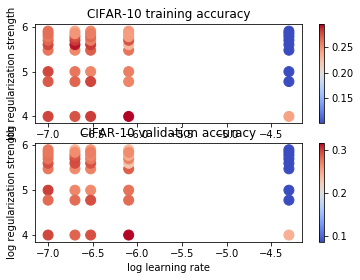

In [26]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [27]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.312000


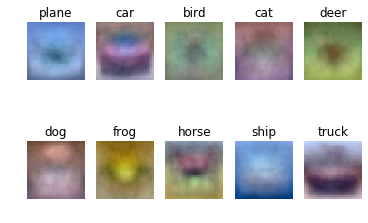

In [28]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
